# Computes s/b and sample composition in a region
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- computes s/b and sample composition in a region defied by a cut
- make plots of s/b as function of cut thresholds
- implements an optimum finding algoritihm for the cut that maximizes s/b (at the end of the notebook)

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [6]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [7]:
 # define your regions here
presel = {
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>250) )",   
#             "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",
            "MET>25": "met_pt>25",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>250) )", 
#             "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
            "MET>30": "met_pt>30",            
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]

In [8]:
### new corrections
samples_dir = {
    "2016":    "../eos/postprocessNov12_2016",
    "2016APV": "../eos/postprocessNov12_2016APV",
    "2017":    "../eos/postprocessNov12_2017",
    "2018":    "../eos/postprocessNov12_2018",
}
events_dict = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict = {**events_dict, **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3841 events
INFO:root:Applying lep_fj_dr08 selection on 3841 events
INFO:root:Applying fj_pt300 selection on 3841 events
INFO:root:Applying tagger>0.5 selection on 298 events
INFO:root:Applying MET>30 selection on 39 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 32 events
INFO:root:tot event weight 47.16143204479031 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 362 events
INFO:root:Applying lep_fj_dr08 selection on 362 events
INFO:root:Applying fj_pt300 selection on 362 events
INFO:root:Applying tagger>0.5 selection on 164 events
INFO:root:Applying MET>30 selection on 42 events
INFO:root:Will fill the DYJets dataframe with the remaining 25 events
INFO:ro

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 129307 events
INFO:root:Applying lep_fj_dr08 selection on 129307 events
INFO:root:Applying fj_pt300 selection on 129307 events
INFO:root:Applying tagger>0.5 selection on 124144 events
INFO:root:Applying MET>30 selection on 3203 events
INFO:root:Will fill the DYJets dataframe with the remaining 2686 events
INFO:root:tot event weight 25.1022175031735 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 921 events
INFO:root:Applying lep_fj_dr08 selection on 921 events
INFO:root:Applying fj_pt300 selection on 921 events
INFO:root:Applying tagger>0.5 selection on 457 events
INFO:root:Applying MET>30 selection on 330 events
INFO:root:Will fill the VBF dataframe with the remaining 253 events
INFO:root:tot event weight 10.443285995730129 

INFO:root:Finding HWmi

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 156188 events
INFO:root:Applying lep_fj_dr08 selection on 156188 events
INFO:root:Applying fj_pt300 selection on 156188 events
INFO:root:Applying tagger>0.5 selection on 146244 events
INFO:root:Applying MET>30 selection on 29670 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 26368 events
INFO:root:tot event weight 1235.1171772314692 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 866757 events
INFO:root:Applying lep_fj_dr08 selection on 866757 events
INFO:root:Applying fj_pt300 selection on 866757 events
INFO:root:Applying tagger>0.5 selection on 543181 events
INFO:root:Applying MET>30 selection on 42489 events
INFO:root:Will fill the TTbar dataframe with the remaining 35514 events
INFO:root:tot event weight 4132.990906953057 

INFO:root:Finding D

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 197217 events
INFO:root:Applying lep_fj_dr08 selection on 197217 events
INFO:root:Applying fj_pt300 selection on 197217 events
INFO:root:Applying tagger>0.5 selection on 189816 events
INFO:root:Applying MET>30 selection on 25150 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 23173 events
INFO:root:tot event weight 239.44462999821684 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 111330 events
INFO:root:Applying lep_fj_dr08 selection on 111330 events
INFO:root:Applying fj_pt300 selection on 111330 events
INFO:root:Applying tagger>0.5 selection on 30279 events
INFO:root:Applying MET>30 selection on 5318 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3775 events
INFO:root:tot event weight 1596.832771431139 

INFO:root:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 107043 events
INFO:root:Applying lep_fj_dr08 selection on 107043 events
INFO:root:Applying fj_pt300 selection on 107043 events
INFO:root:Applying tagger>0.5 selection on 54003 events
INFO:root:Applying MET>30 selection on 7918 events
INFO:root:Will fill the Data dataframe with the remaining 5938 events
INFO:root:tot event weight 5938.0 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 47719 events
INFO:root:Applying lep_fj_dr08 selection on 47719 events
INFO:root:Applying fj_pt300 selection on 47719 events
INFO:root:Applying tagger>0.5 selection on 24177 events
INFO:root:Applying MET>30 selection on 3620 events
INFO:root:Will fill the Data dataframe with the remaining 2738 events
INFO:root:tot event weight 2738.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:No parquet file for WJetsToLNu_HT-70To100
INFO:root

INFO:root:tot event weight 1.808244761604093 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2412 events
INFO:root:Applying lep_fj_dr08 selection on 2412 events
INFO:root:Applying fj_pt300 selection on 2412 events
INFO:root:Applying tagger>0.5 selection on 2359 events
INFO:root:Applying MET>30 selection on 207 events
INFO:root:Will fill the QCD dataframe with the remaining 149 events
INFO:root:tot event weight 46.531664105913045 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1567 events
INFO:root:Applying lep_fj_dr08 selection on 1567 events
INFO:root:Applying fj_pt300 selection on 1567 events
INFO:root:Applying tagger>0.5 selection on 1508 events
INFO:root:Applying MET>30 selection on 178 events
INFO:root:Will fill the QCD dataframe with th

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1058 events
INFO:root:Applying lep_fj_dr08 selection on 1058 events
INFO:root:Applying fj_pt300 selection on 1058 events
INFO:root:Applying tagger>0.5 selection on 904 events
INFO:root:Applying MET>30 selection on 161 events
INFO:root:Will fill the WZQQ dataframe with the remaining 94 events
INFO:root:tot event weight 30.679333991250473 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 920 events
INFO:root:Applying lep_fj_dr08 selection on 920 events
INFO:root:Applying fj_pt300 selection on 920 events
INFO:root:Applying tagger>0.5 selection on 511 events
INFO:root:Applying MET>30 selection on 54 events
INFO:root:Will fill the QCD dataframe with the remaining 34 events
INFO:root:tot event weight 4670.273387937956 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should 

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 57465 events
INFO:root:Applying lep_fj_dr08 selection on 57465 events
INFO:root:Applying fj_pt300 selection on 57465 events
INFO:root:Applying tagger>0.5 selection on 55934 events
INFO:root:Applying MET>30 selection on 2748 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2623 events
INFO:root:tot event weight 2.2099438087976297 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11238 events
INFO:root:Applying lep_fj_dr08 selection on 11238 events
INFO:root:Applying fj_pt300 selection on 11238 events
INFO:root:Applying tagger>0.5 selection on 7322 events
INFO:root:Applying MET>30 selection on 3442 events
INFO:root:Will fill the ttH dataframe with the remaining 2955 events
INFO:root:tot event weight 10.645511238614098 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
IN

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 275765 events
INFO:root:Applying lep_fj_dr08 selection on 275765 events
INFO:root:Applying fj_pt300 selection on 275765 events
INFO:root:Applying tagger>0.5 selection on 124408 events
INFO:root:Applying MET>30 selection on 17215 events
INFO:root:Will fill the DYJets dataframe with the remaining 10253 events
INFO:root:tot event weight 532.7596617279446 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017F
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4407 events
INFO:root:Applying lep_fj_dr08 selection on 4407 events
INFO:root:Applying fj_pt300 selection on 4407 events
INFO:root:Applying tagger>0.5 selection on 391 events
INFO:root:Applying MET>25 selection on 52 events
INFO:root:Wil

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 23063 events
INFO:root:Applying lep_fj_dr08 selection on 23063 events
INFO:root:Applying fj_pt300 selection on 23063 events
INFO:root:Applying tagger>0.5 selection on 21216 events
INFO:root:Applying MET>25 selection on 1934 events
INFO:root:Will fill the DYJets dataframe with the remaining 1784 events
INFO:root:tot event weight 15.812555169350478 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1426 events
INFO:root:Applying lep_fj_dr08 selection on 1426 events
INFO:root:Applying fj_pt300 selection on 1426 events
INFO:root:Applying tagger>0.5 selection on 738 events
INFO:root:Applying MET>25 selection on 541 events
INFO:root:Will fill the VBF dataframe with the remaining 439 events
INFO:root:tot event weight 18.065975180579404 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 213045 events
INFO:root:Applying lep_fj_dr08 selection on 213045 events
INFO:root:Applying fj_pt300 selection on 213045 events
INFO:root:Applying tagger>0.5 selection on 200346 events
INFO:root:Applying MET>25 selection on 48857 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 45224 events
INFO:root:tot event weight 2209.9889791717665 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 943577 events
INFO:root:Applying lep_fj_dr08 selection on 943577 events
INFO:root:Applying fj_pt300 selection on 943577 events
INFO:root:Applying tagger>0.5 selection on 586151 events
INFO:root:Applying MET>25 selection on 52385 events
INFO:root:Will fill the TTbar dataframe with the remaining 46350 events
INFO:root:tot event weight 5416.206235788888 

INFO:root:Finding D

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 270374 events
INFO:root:Applying lep_fj_dr08 selection on 270374 events
INFO:root:Applying fj_pt300 selection on 270374 events
INFO:root:Applying tagger>0.5 selection on 261176 events
INFO:root:Applying MET>25 selection on 46723 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 44355 events
INFO:root:tot event weight 471.35729079323403 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 138315 events
INFO:root:Applying lep_fj_dr08 selection on 138315 events
INFO:root:Applying fj_pt300 selection on 138315 events
INFO:root:Applying tagger>0.5 selection on 34601 events
INFO:root:Applying MET>25 selection on 7521 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5922 events
INFO:root:tot event weight 2629.4281710864916 

INFO:root

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 91731 events
INFO:root:Applying lep_fj_dr08 selection on 91731 events
INFO:root:Applying fj_pt300 selection on 91731 events
INFO:root:Applying tagger>0.5 selection on 44364 events
INFO:root:Applying MET>25 selection on 8597 events
INFO:root:Will fill the Data dataframe with the remaining 7253 events
INFO:root:tot event weight 7253.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 36615 events
INFO:root:Applying lep_fj_dr08 selection on 36615 events
INFO:root:Applying fj_pt300 selection on 36615 events
INFO:root:Applying tagger>0.5 selection on 25283 events
INFO:root:Applying MET>25 selection on 1425 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1280 events
INFO:root:tot event weight 4.221881718963689 

INFO:root:Finding SingleMuon_Run2017D samples and should combine them under 

INFO:root:Applying lep_fj_dr08 selection on 1477 events
INFO:root:Applying fj_pt300 selection on 1477 events
INFO:root:Applying tagger>0.5 selection on 1453 events
INFO:root:Applying MET>25 selection on 174 events
INFO:root:Will fill the QCD dataframe with the remaining 165 events
INFO:root:tot event weight 2.4428101754527756 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1277 events
INFO:root:Applying lep_fj_dr08 selection on 1277 events
INFO:root:Applying fj_pt300 selection on 1277 events
INFO:root:Applying tagger>0.5 selection on 1257 events
INFO:root:Applying MET>25 selection on 175 events
INFO:root:Will fill the QCD dataframe with the remaining 156 events
INFO:root:tot event weight 48.87221952744509 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 se

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1106 events
INFO:root:Applying lep_fj_dr08 selection on 1106 events
INFO:root:Applying fj_pt300 selection on 1106 events
INFO:root:Applying tagger>0.5 selection on 1002 events
INFO:root:Applying MET>25 selection on 311 events
INFO:root:Will fill the WZQQ dataframe with the remaining 271 events
INFO:root:tot event weight 27.30697078153784 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 997 events
INFO:root:Applying lep_fj_dr08 selection on 997 events
INFO:root:Applying fj_pt300 selection on 997 events
INFO:root:Applying tagger>0.5 selection on 712 events
INFO:root:Applying MET>25 selection on 117 events
INFO:root:Will fill the WZQQ dataframe with the remaining 102 events
INFO:root:tot event weight 13.502575870366075 

INFO:root:Finding QCD_Pt_170to300 samples and sh

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 175965 events
INFO:root:Applying lep_fj_dr08 selection on 175965 events
INFO:root:Applying fj_pt300 selection on 175965 events
INFO:root:Applying tagger>0.5 selection on 154367 events
INFO:root:Applying MET>25 selection on 43242 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 38932 events
INFO:root:tot event weight 4073.197156040849 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 682 events
INFO:root:Applying lep_fj_dr08 selection on 682 events
INFO:root:Applying fj_pt300 selection on 682 events
INFO:root:Applying tagger>0.5 selection on 483 events
INFO:root:Applying MET>25 selection on 157 events
INFO:root:Will fill the WZQQ dataframe with the remaining 119 events
INFO:root:tot event weight 30.74736555478367 

INFO:root:Finding WJetsToLNu_HT-2

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 77865 events
INFO:root:Applying lep_fj_dr08 selection on 77865 events
INFO:root:Applying fj_pt300 selection on 77865 events
INFO:root:Applying tagger>0.5 selection on 76169 events
INFO:root:Applying MET>25 selection on 6743 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6525 events
INFO:root:tot event weight 5.763150918923518 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10498 events
INFO:root:Applying lep_fj_dr08 selection on 10498 events
INFO:root:Applying fj_pt300 selection on 10498 events
INFO:root:Applying tagger>0.5 selection on 7042 events
INFO:root:Applying MET>25 selection on 3746 events
INFO:root:Will fill the ttH dataframe with the remaining 3329 events
INFO:root:tot event weight 11.40989053971733 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 199435 events
INFO:root:Applying lep_fj_dr08 selection on 199435 events
INFO:root:Applying fj_pt300 selection on 199435 events
INFO:root:Applying tagger>0.5 selection on 78840 events
INFO:root:Applying MET>25 selection on 15213 events
INFO:root:Will fill the DYJets dataframe with the remaining 10734 events
INFO:root:tot event weight 587.4116168496364 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 134578 events
INFO:root:Applying lep_fj_dr08 selection on 134578 events
INFO:root:Applying fj_pt300 selection on 134578 events
INFO:root:Applying tagger>0.5 selection on 63927 events
INFO:root:Applying MET>25 selection on 12582 events
INFO:root:Will fill the Data dataframe with the remaining 10928 events
INFO:root:tot event weight 10928.0 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJe

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125157 events
INFO:root:Applying lep_fj_dr08 selection on 125157 events
INFO:root:Applying fj_pt300 selection on 125157 events
INFO:root:Applying tagger>0.5 selection on 119189 events
INFO:root:Applying MET>30 selection on 3113 events
INFO:root:Will fill the DYJets dataframe with the remaining 2560 events
INFO:root:tot event weight 9.994916182418102 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 452 events
INFO:root:Applying lep_fj_dr08 selection on 452 events
INFO:root:Applying fj_pt300 selection on 452 events
INFO:root:Applying tagger>0.5 selection on 221 events
INFO:root:Applying MET>30 selection on 154 events
INFO:root:Will fill the VBF dataframe with the remaining 109 events
INFO:root:tot event weight 3.8067215221835284 

INFO:root:Finding Sin

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 63781 events
INFO:root:Applying lep_fj_dr08 selection on 63781 events
INFO:root:Applying fj_pt300 selection on 63781 events
INFO:root:Applying tagger>0.5 selection on 59702 events
INFO:root:Applying MET>30 selection on 10809 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 9554 events
INFO:root:tot event weight 423.2910595035595 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 75025 events
INFO:root:Applying lep_fj_dr08 selection on 75025 events
INFO:root:Applying fj_pt300 selection on 75025 events
INFO:root:Applying tagger>0.5 selection on 46531 events
INFO:root:Applying MET>30 selection on 3766 events
INFO:root:Will fill the TTbar dataframe with the remaining 3104 events
INFO:root:tot event weight 1610.83769051268 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under D

INFO:root:Applying lep_fj_dr08 selection on 210 events
INFO:root:Applying fj_pt300 selection on 210 events
INFO:root:Applying tagger>0.5 selection on 206 events
INFO:root:Applying MET>30 selection on 0 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5241 events
INFO:root:Applying lep_fj_dr08 selection on 5241 events
INFO:root:Applying fj_pt300 selection on 5241 events
INFO:root:Applying tagger>0.5 selection on 2868 events
INFO:root:Applying MET>30 selection on 1894 events
INFO:root:Will fill the VH dataframe with the remaining 1448 events
INFO:root:tot event weight 1.4435939602528243 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selectio

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 10095 events
INFO:root:Applying lep_fj_dr08 selection on 10095 events
INFO:root:Applying fj_pt300 selection on 10095 events
INFO:root:Applying tagger>0.5 selection on 7138 events
INFO:root:Applying MET>30 selection on 379 events
INFO:root:Will fill the SingleTop dataframe with the remaining 316 events
INFO:root:tot event weight 1.0712209898923006 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20179 events
INFO:root:Applying lep_fj_dr08 selection on 20179 events
INFO:root:Applying fj_pt300 selection on 20179 events
INFO:root:Applying tagger>0.5 selection on 8021 events
INFO:root:Applying MET>30 selection on 1733 events
INFO:root:Will fill the DYJets dataframe with the remaining 896 events
INFO:root:tot event weight 55.60715130550405 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1129 events
INFO:root:Applying lep_fj_dr08 selection on 1129 events
INFO:root:Applying fj_pt300 selection on 1129 events
INFO:root:Applying tagger>0.5 selection on 1058 events
INFO:root:Applying MET>30 selection on 165 events
INFO:root:Will fill the WZQQ dataframe with the remaining 106 events
INFO:root:tot event weight 10.483348897688954 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 624 events
INFO:root:Applying lep_fj_dr08 selection on 624 events
INFO:root:Applying fj_pt300 selection on 624 events
INFO:root:Applying tagger>0.5 selection on 518 events
INFO:root:Applying MET>30 selection on 49 events
INFO:root:Will fill the WZQQ dataframe with the remaining 25 events
INFO:root:tot event weight 2.5515648312327066 

INFO:root:Finding QCD_Pt_170to300 samples and sho

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49996 events
INFO:root:Applying lep_fj_dr08 selection on 49996 events
INFO:root:Applying fj_pt300 selection on 49996 events
INFO:root:Applying tagger>0.5 selection on 43597 events
INFO:root:Applying MET>30 selection on 9705 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8134 events
INFO:root:tot event weight 810.6871494774654 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 761 events
INFO:root:Applying lep_fj_dr08 selection on 761 events
INFO:root:Applying fj_pt300 selection on 761 events
INFO:root:Applying tagger>0.5 selection on 641 events
INFO:root:Applying MET>30 selection on 123 events
INFO:root:Will fill the WZQQ dataframe with the remaining 58 events
INFO:root:tot event weight 12.37620184824438 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 10323 events
INFO:root:Applying lep_fj_dr08 selection on 10323 events
INFO:root:Applying fj_pt300 selection on 10323 events
INFO:root:Applying tagger>0.5 selection on 6696 events
INFO:root:Applying MET>30 selection on 3079 events
INFO:root:Will fill the ttH dataframe with the remaining 2595 events
INFO:root:tot event weight 3.9038725695308933 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt300 selection on 767 events
INFO:root:Applying tagger>0.5 selection on 732 events
INFO:root:Applying MET>30 selection on 93 events
INFO:root:Will fill the WZQQ dataframe with the remaining 61 events
INFO:root:tot event weight 3.4442627184768395 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Us

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 259992 events
INFO:root:Applying lep_fj_dr08 selection on 259992 events
INFO:root:Applying fj_pt300 selection on 259992 events
INFO:root:Applying tagger>0.5 selection on 115050 events
INFO:root:Applying MET>30 selection on 14847 events
INFO:root:Will fill the DYJets dataframe with the remaining 7992 events
INFO:root:tot event weight 175.71831362723776 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1273 events
INFO:root:Applying lep_fj_dr08 selection on 1273 events
INFO:root:Applying fj_pt300 selection on 1273 events
INFO:root:Applying tagger>0.5 selection on 102 events
INFO:root:Applying MET>25 selection on 22 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 20 events
INFO:root:tot event weight 33.40600752412349 

INFO:root:Finding SingleM

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 78929 events
INFO:root:Applying lep_fj_dr08 selection on 78929 events
INFO:root:Applying fj_pt300 selection on 78929 events
INFO:root:Applying tagger>0.5 selection on 37806 events
INFO:root:Applying MET>25 selection on 7555 events
INFO:root:Will fill the Data dataframe with the remaining 6373 events
INFO:root:tot event weight 6373.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 3808 events
INFO:root:Applying lep_fj_dr08 selection on 3808 events
INFO:root:Applying fj_pt300 selection on 3808 events
INFO:root:Applying tagger>0.5 selection on 1820 events
INFO:root:Applying MET>25 selection on 367 events
INFO:root:Will fill the Data dataframe with the remaining 319 events
INFO:root:tot event weight 319.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_d

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 92490 events
INFO:root:Applying lep_fj_dr08 selection on 92490 events
INFO:root:Applying fj_pt300 selection on 92490 events
INFO:root:Applying tagger>0.5 selection on 86639 events
INFO:root:Applying MET>25 selection on 20363 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 18828 events
INFO:root:tot event weight 860.7642501542507 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 87877 events
INFO:root:Applying lep_fj_dr08 selection on 87877 events
INFO:root:Applying fj_pt300 selection on 87877 events
INFO:root:Applying tagger>0.5 selection on 53712 events
INFO:root:Applying MET>25 selection on 5182 events
INFO:root:Will fill the TTbar dataframe with the remaining 4547 events
INFO:root:tot event weight 2290.095825078704 

INFO:root:Finding SingleElectron_Run2016G samples and should combine them under

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying fj_pt300 selection on 14737 events
INFO:root:Applying tagger>0.5 selection on 10077 events
INFO:root:Applying MET>25 selection on 663 events
INFO:root:Will fill the SingleTop dataframe with the remaining 578 events
INFO:root:tot event weight 1.9428231064562762 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 23982 events
INFO:root:Applying lep_fj_dr08 selection on 23982 events
INFO:root:Applying fj_pt300 selection on 23982 events
INFO:root:Applying tagger>0.5 selection on 9581 events
INFO:root:Applying MET>25 selection on 2379 events
INFO:root:Will fill the DYJets dataframe with the remaining 1524 events
INFO:root:tot event weight 112.63393493420631 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 461 events
INFO:r

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 4707 events
INFO:root:Applying lep_fj_dr08 selection on 4707 events
INFO:root:Applying fj_pt300 selection on 4707 events
INFO:root:Applying tagger>0.5 selection on 4607 events
INFO:root:Applying MET>25 selection on 571 events
INFO:root:Will fill the QCD dataframe with the remaining 512 events
INFO:root:tot event weight 19.480827557650983 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2585 events
INFO:root:Applying lep_fj_dr08 selection on 2585 events
INFO:root:Applying fj_pt300 selection on 2585 events
INFO:root:Applying tagger>0.5 selection on 2245 events
INFO:root:Applying MET>25 selection on 320 events
INFO:root:Will fill the QCD dataframe with the remaining 249 events
INFO:root:tot event weight 504.50229679402264 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Usi

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 73761 events
INFO:root:Applying lep_fj_dr08 selection on 73761 events
INFO:root:Applying fj_pt300 selection on 73761 events
INFO:root:Applying tagger>0.5 selection on 64187 events
INFO:root:Applying MET>25 selection on 17470 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15628 events
INFO:root:tot event weight 1591.7350310529105 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 400 events
INFO:root:Applying lep_fj_dr08 selection on 400 events
INFO:root:Applying fj_pt300 selection on 400 events
INFO:root:Applying tagger>0.5 selection on 284 events
INFO:root:Applying MET>25 selection on 107 events
INFO:root:Will fill the WZQQ dataframe with the remaining 75 events
INFO:root:tot event weight 14.719191095761749 

INFO:root:Finding WJetsToLNu_HT-2500

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying fj_pt300 selection on 48459 events
INFO:root:Applying tagger>0.5 selection on 47401 events
INFO:root:Applying MET>25 selection on 4074 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3943 events
INFO:root:tot event weight 2.287258163495943 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10484 events
INFO:root:Applying lep_fj_dr08 selection on 10484 events
INFO:root:Applying fj_pt300 selection on 10484 events
INFO:root:Applying tagger>0.5 selection on 6770 events
INFO:root:Applying MET>25 selection on 3695 events
INFO:root:Will fill the ttH dataframe with the remaining 3235 events
INFO:root:tot event weight 4.65832233187011 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 782 events
INFO:root:Apply

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 187926 events
INFO:root:Applying lep_fj_dr08 selection on 187926 events
INFO:root:Applying fj_pt300 selection on 187926 events
INFO:root:Applying tagger>0.5 selection on 72658 events
INFO:root:Applying MET>25 selection on 14419 events
INFO:root:Will fill the DYJets dataframe with the remaining 9463 events
INFO:root:tot event weight 204.6756622211512 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1272 events
INFO:root:Applying lep_fj_dr08 selection on 1272 events
INFO:root:Applying fj_pt300 selection on 1272 events
INFO:root:Applying tagger>0.5 selection on 76 events
INFO:root:Applying MET>30 selection on 12 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 9 events
INFO:root:tot event weight 12.496544720057454 

INFO:root:Finding DYJetsToLL

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 133624 events
INFO:root:Applying lep_fj_dr08 selection on 133624 events
INFO:root:Applying fj_pt300 selection on 133624 events
INFO:root:Applying tagger>0.5 selection on 127270 events
INFO:root:Applying MET>30 selection on 3353 events
INFO:root:Will fill the DYJets dataframe with the remaining 2794 events
INFO:root:tot event weight 10.376205042450554 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 421 events
INFO:root:Applying lep_fj_dr08 selection on 421 events
INFO:root:Applying fj_pt300 selection on 421 events
INFO:root:Applying tagger>0.5 selection on 190 events
INFO:root:Applying MET>30 selection on 135 events
INFO:root:Will fill the VBF dataframe with the remaining 111 events
INFO:root:tot event weight 4.677655266141828 

INFO:root:Finding HWm

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 71245 events
INFO:root:Applying lep_fj_dr08 selection on 71245 events
INFO:root:Applying fj_pt300 selection on 71245 events
INFO:root:Applying tagger>0.5 selection on 66345 events
INFO:root:Applying MET>30 selection on 12231 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10763 events
INFO:root:tot event weight 460.79620003076275 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 90915 events
INFO:root:Applying lep_fj_dr08 selection on 90915 events
INFO:root:Applying fj_pt300 selection on 90915 events
INFO:root:Applying tagger>0.5 selection on 55836 events
INFO:root:Applying MET>30 selection on 4643 events
INFO:root:Will fill the TTbar dataframe with the remaining 3806 events
INFO:root:tot event weight 1701.342546324012 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them under

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:Applying lep_fj_dr003 selection on 77435 events
INFO:root:Applying lep_fj_dr08 selection on 77435 events
INFO:root:Applying fj_pt300 selection on 77435 events
INFO:root:Applying tagger>0.5 selection on 74364 events
INFO:root:Applying MET>30 selection on 8866 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8096 events
INFO:root:tot event weight 86.85590288715629 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 40308 events
INFO:root:Applying lep_fj_dr08 selection on 40308 events
INFO:root:Applying fj_pt300 selection on 40308 events
INFO:root:Applying tagger>0.5 selection on 9664 events
INFO:root:Applying MET>30 selection on 1594 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1031 events
INFO:root:tot event weight 471.48873403330316 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and should com

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 25395 events
INFO:root:Applying lep_fj_dr08 selection on 25395 events
INFO:root:Applying fj_pt300 selection on 25395 events
INFO:root:Applying tagger>0.5 selection on 12702 events
INFO:root:Applying MET>30 selection on 1867 events
INFO:root:Will fill the Data dataframe with the remaining 1420 events
INFO:root:tot event weight 1420.0 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11010 events
INFO:root:Applying lep_fj_dr08 selection on 11010 events
INFO:root:Applying fj_pt300 selection on 11010 events
INFO:root:Applying tagger>0.5 selection on 4338 events
INFO:root:Applying MET>30 selection on 937 events
INFO:root:Will fill the DYJets dataframe with the remaining 491 events
INFO:root:tot event weight 67.47344962038649 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:--->

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying MET>30 selection on 3235 events
INFO:root:Will fill the Data dataframe with the remaining 2392 events
INFO:root:tot event weight 2392.0 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6524 events
INFO:root:Applying lep_fj_dr08 selection on 6524 events
INFO:root:Applying fj_pt300 selection on 6524 events
INFO:root:Applying tagger>0.5 selection on 6387 events
INFO:root:Applying MET>30 selection on 504 events
INFO:root:Will fill the QCD dataframe with the remaining 361 events
INFO:root:tot event weight 18.386842965350382 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4348 events
INFO:root:Applying lep_fj_dr08 selection on 4348 events
INFO:root:Applying fj_pt300 selection on 4348 events
INFO:root:Applying tagger>0.5 selection 

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49939 events
INFO:root:Applying lep_fj_dr08 selection on 49939 events
INFO:root:Applying fj_pt300 selection on 49939 events
INFO:root:Applying tagger>0.5 selection on 43404 events
INFO:root:Applying MET>30 selection on 9639 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8186 events
INFO:root:tot event weight 886.8570947706944 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 25541 events
INFO:root:Applying lep_fj_dr08 selection on 25541 events
INFO:root:Applying fj_pt300 selection on 25541 events
INFO:root:Applying tagger>0.5 selection on 12774 events
INFO:root:Applying MET>30 selection on 1932 events
INFO:root:Will fill the Data dataframe with the remaining 1403 events
INFO:root:tot event weight 1403.0 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 8732 events
INFO:root:Applying lep_fj_dr08 selection on 8732 events
INFO:root:Applying fj_pt300 selection on 8732 events
INFO:root:Applying tagger>0.5 selection on 5636 events
INFO:root:Applying MET>30 selection on 2681 events
INFO:root:Will fill the ttH dataframe with the remaining 2250 events
INFO:root:tot event weight 4.167170378645903 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 518 events
INFO:root:Applying lep_fj_dr08 selection on 518 events
INFO:root:Applying fj_pt300 selection on 518 events
INFO:root:Applying tagger>0.5 selection on 485 events
INFO:root:Applying MET>30 selection on 65 events
INFO:root:Will fill the WZQQ dataframe with the remaining 46 events
INFO:root:tot event weight 4.000083767677085 

INFO:root:Finding QCD_Pt_800to1000 samples and sho

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 262038 events
INFO:root:Applying lep_fj_dr08 selection on 262038 events
INFO:root:Applying fj_pt300 selection on 262038 events
INFO:root:Applying tagger>0.5 selection on 114501 events
INFO:root:Applying MET>30 selection on 14694 events
INFO:root:Will fill the DYJets dataframe with the remaining 7773 events
INFO:root:tot event weight 181.6131647311586 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1391 events
INFO:root:Applying lep_fj_dr08 selection on 1391 events
INFO:root:Applying fj_pt300 selection on 1391 events
INFO:root:Applying tagger>0.5 selection on 99 events
INFO:root:Applying MET>25 selection on 24 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 20 events
INFO:root:tot event weight 31.28901196073102 

INFO:root:Finding DYJetsToL

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 657 events
INFO:root:Applying lep_fj_dr08 selection on 657 events
INFO:root:Applying fj_pt300 selection on 657 events
INFO:root:Applying tagger>0.5 selection on 296 events
INFO:root:Applying MET>25 selection on 215 events
INFO:root:Will fill the VBF dataframe with the remaining 170 events
INFO:root:tot event weight 7.1450015564772436 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5281 events
INFO:root:Applying lep_fj_dr08 selection on 5281 events
INFO:root:Applying fj_pt300 selection on 5281 events
INFO:root:Applying tagger>0.5 selection on 2780 events
INFO:root:Applying MET>25 selection on 2091 events
INFO:root:Will fill the VH dataframe with the remaining 1736 events
INFO:root:tot event weight 1.2917325061201783 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples a

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 105815 events
INFO:root:Applying lep_fj_dr08 selection on 105815 events
INFO:root:Applying fj_pt300 selection on 105815 events
INFO:root:Applying tagger>0.5 selection on 99178 events
INFO:root:Applying MET>25 selection on 23401 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 21538 events
INFO:root:tot event weight 954.6200652558919 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 107586 events
INFO:root:Applying lep_fj_dr08 selection on 107586 events
INFO:root:Applying fj_pt300 selection on 107586 events
INFO:root:Applying tagger>0.5 selection on 64909 events
INFO:root:Applying MET>25 selection on 6531 events
INFO:root:Will fill the TTbar dataframe with the remaining 5753 events
INFO:root:tot event weight 2556.7252818468696 

INFO:root:Finding DYJet

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 116504 events
INFO:root:Applying lep_fj_dr08 selection on 116504 events
INFO:root:Applying fj_pt300 selection on 116504 events
INFO:root:Applying tagger>0.5 selection on 112508 events
INFO:root:Applying MET>25 selection on 19491 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 18448 events
INFO:root:tot event weight 207.7509428789348 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 52559 events
INFO:root:Applying lep_fj_dr08 selection on 52559 events
INFO:root:Applying fj_pt300 selection on 52559 events
INFO:root:Applying tagger>0.5 selection on 10977 events
INFO:root:Applying MET>25 selection on 2371 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1788 events
INFO:root:tot event weight 831.6193283029454 

INFO:root:Find

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6569 events
INFO:root:Applying lep_fj_dr08 selection on 6569 events
INFO:root:Applying fj_pt300 selection on 6569 events
INFO:root:Applying tagger>0.5 selection on 3609 events
INFO:root:Applying MET>25 selection on 2553 events
INFO:root:Will fill the VH dataframe with the remaining 2151 events
INFO:root:tot event weight 2.1644843020141273 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 74 events
INFO:root:Applying lep_fj_dr08 selection on 74 events
INFO:root:Applying fj_pt300 selection on 74 events
INFO:root:Applying tagger>0.5 selection on 22 events
INFO:root:Applying MET>25 selection on 7 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6 events
INFO:root:tot event weight 12.623838591586797 

INFO:root:Finding ST_s-channel_4f_leptonDecays 

INFO:root:Applying fj_pt300 selection on 1537 events
INFO:root:Applying tagger>0.5 selection on 1511 events
INFO:root:Applying MET>25 selection on 162 events
INFO:root:Will fill the QCD dataframe with the remaining 148 events
INFO:root:tot event weight 1.0847242653845188 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016D_HIPM
INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3829 events


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr08 selection on 3829 events
INFO:root:Applying fj_pt300 selection on 3829 events
INFO:root:Applying tagger>0.5 selection on 3749 events
INFO:root:Applying MET>25 selection on 514 events
INFO:root:Will fill the QCD dataframe with the remaining 456 events
INFO:root:tot event weight 23.350374201640264 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2414 events
INFO:root:Applying lep_fj_dr08 selection on 2414 events
INFO:root:Applying fj_pt300 selection on 2414 events
INFO:root:Applying tagger>0.5 selection on 2097 events
INFO:root:Applying MET>25 selection on 291 events
INFO:root:Will fill the QCD dataframe with the remaining 235 events
INFO:root:tot event weight 542.3341145734819 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_d

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49339 events
INFO:root:Applying lep_fj_dr08 selection on 49339 events
INFO:root:Applying fj_pt300 selection on 49339 events
INFO:root:Applying tagger>0.5 selection on 24054 events
INFO:root:Applying MET>25 selection on 4856 events
INFO:root:Will fill the Data dataframe with the remaining 4014 events
INFO:root:tot event weight 4014.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 33898 events
INFO:root:Applying lep_fj_dr08 selection on 33898 events
INFO:root:Applying fj_pt300 selection on 33898 events
INFO:root:Applying tagger>0.5 selection on 16274 events
INFO:root:Applying MET>25 selection on 3306 events
INFO:root:Will fill the Data dataframe with the remaining 2774 events
INFO:root:tot event weight 2774.0 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 53568 events
INFO:root:Applying lep_fj_dr08 selection on 53568 events
INFO:root:Applying fj_pt300 selection on 53568 events
INFO:root:Applying tagger>0.5 selection on 52314 events
INFO:root:Applying MET>25 selection on 4389 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4236 events
INFO:root:tot event weight 2.4595908483218576 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 8975 events
INFO:root:Applying lep_fj_dr08 selection on 8975 events
INFO:root:Applying fj_pt300 selection on 8975 events
INFO:root:Applying tagger>0.5 selection on 5869 events
INFO:root:Applying MET>25 selection on 3228 events
INFO:root:Will fill the ttH dataframe with the remaining 2863 events
INFO:root:tot event weight 5.319275874135768 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:r

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 190890 events
INFO:root:Applying lep_fj_dr08 selection on 190890 events
INFO:root:Applying fj_pt300 selection on 190890 events
INFO:root:Applying tagger>0.5 selection on 72106 events
INFO:root:Applying MET>25 selection on 14379 events
INFO:root:Will fill the DYJets dataframe with the remaining 9280 events
INFO:root:tot event weight 205.12923952782668 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2866 events
INFO:root:Applying lep_fj_dr08 selection on 2866 events
INFO:root:Applying fj_pt300 selection on 2866 events
INFO:root:Applying tagger>0.5 selection on 243 events
INFO:root:Applying MET>30 selection on 35 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 30 events
INFO:root:tot event weight 62.110688353663946 

INFO:root:Finding DYJetsT

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 115308 events
INFO:root:Applying lep_fj_dr08 selection on 115308 events
INFO:root:Applying fj_pt300 selection on 115308 events
INFO:root:Applying tagger>0.5 selection on 110356 events
INFO:root:Applying MET>30 selection on 2771 events
INFO:root:Will fill the DYJets dataframe with the remaining 2341 events
INFO:root:tot event weight 29.003662629246023 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 401 events
INFO:root:Applying lep_fj_dr08 selection on 401 events
INFO:root:Applying fj_pt300 selection on 401 events
INFO:root:Applying tagger>0.5 selection on 186 events
INFO:root:Applying MET>30 selection on 126 events
INFO:root:Will fill the VBF dataframe with the remaining 97 events
INFO:root:tot event weight 12.64222793204763 

INFO:root:Finding HWmi

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 200598 events
INFO:root:Applying lep_fj_dr08 selection on 200598 events
INFO:root:Applying fj_pt300 selection on 200598 events
INFO:root:Applying tagger>0.5 selection on 187953 events
INFO:root:Applying MET>30 selection on 38051 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 33855 events
INFO:root:tot event weight 1574.3006275371017 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 739094 events
INFO:root:Applying lep_fj_dr08 selection on 739094 events
INFO:root:Applying fj_pt300 selection on 739094 events
INFO:root:Applying tagger>0.5 selection on 459972 events
INFO:root:Applying MET>30 selection on 36165 events
INFO:root:Will fill the TTbar dataframe with the remaining 30231 events
INFO:root:tot event weight 5056.0535445656515 

INFO:root:Finding 

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 229745 events
INFO:root:Applying lep_fj_dr08 selection on 229745 events
INFO:root:Applying fj_pt300 selection on 229745 events
INFO:root:Applying tagger>0.5 selection on 221361 events
INFO:root:Applying MET>30 selection on 29062 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 26732 events
INFO:root:tot event weight 297.9588762095576 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122861 events
INFO:root:Applying lep_fj_dr08 selection on 122861 events
INFO:root:Applying fj_pt300 selection on 122861 events
INFO:root:Applying tagger>0.5 selection on 31520 events
INFO:root:Applying MET>30 selection on 5479 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3822 events
INFO:root:tot event weight 1732.202117690203 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 136321 events
INFO:root:Applying lep_fj_dr08 selection on 136321 events
INFO:root:Applying fj_pt300 selection on 136321 events
INFO:root:Applying tagger>0.5 selection on 68948 events
INFO:root:Applying MET>30 selection on 10198 events
INFO:root:Will fill the Data dataframe with the remaining 7886 events
INFO:root:tot event weight 7886.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 172 events
INFO:root:Applying lep_fj_dr08 selection on 172 events
INFO:root:Applying fj_pt300 selection on 172 events
INFO:root:Applying tagger>0.5 selection on 52 events
INFO:root:Applying MET>30 selection on 10 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10 events
INFO:root:tot event weight 16.260406324668 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
I

INFO:root:Will fill the QCD dataframe with the remaining 132 events
INFO:root:tot event weight 60.764598282110725 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1302 events
INFO:root:Applying lep_fj_dr08 selection on 1302 events
INFO:root:Applying fj_pt300 selection on 1302 events
INFO:root:Applying tagger>0.5 selection on 1245 events
INFO:root:Applying MET>30 selection on 169 events
INFO:root:Will fill the QCD dataframe with the remaining 115 events
INFO:root:tot event weight 2306.316331730875 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 1880 events
INFO:root:Applying lep_fj_dr08 selection on 1880 events
INFO:root:Applying fj_pt300 selection on 1880 events
INFO:root:Applying tagger>0.5 selection on 1783 events
INFO:root:Applying MET>30 selection on 347 events
INFO:root:Will fill the WZQQ dataframe with the remaining 229 events
INFO:root:tot event weight 40.36864300214758 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 916 events
INFO:root:Applying lep_fj_dr08 selection on 916 events
INFO:root:Applying fj_pt300 selection on 916 events
INFO:root:Applying tagger>0.5 selection on 752 events
INFO:root:Applying MET>30 selection on 129 events
INFO:root:Will fill the WZQQ dataframe with the remaining 77 events
INFO:root:tot event weight 14.766452789429932 

INFO:root:Finding QCD_Pt_170to300 samples and should combine them under QCD
INFO:root:---> Using a

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 158958 events
INFO:root:Applying lep_fj_dr08 selection on 158958 events
INFO:root:Applying fj_pt300 selection on 158958 events
INFO:root:Applying tagger>0.5 selection on 138910 events
INFO:root:Applying MET>30 selection on 33842 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 28921 events
INFO:root:tot event weight 3022.1695741723415 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1249 events
INFO:root:Applying lep_fj_dr08 selection on 1249 events
INFO:root:Applying fj_pt300 selection on 1249 events
INFO:root:Applying tagger>0.5 selection on 1074 events
INFO:root:Applying MET>30 selection on 226 events
INFO:root:Will fill the WZQQ dataframe with the remaining 142 events
INFO:root:tot event weight 53.143125388801664 

INFO:root:Finding WJetsToLN

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 92281 events
INFO:root:Applying lep_fj_dr08 selection on 92281 events
INFO:root:Applying fj_pt300 selection on 92281 events
INFO:root:Applying tagger>0.5 selection on 89979 events
INFO:root:Applying MET>30 selection on 4381 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 4159 events
INFO:root:tot event weight 2.85250195216937 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 30234 events
INFO:root:Applying lep_fj_dr08 selection on 30234 events
INFO:root:Applying fj_pt300 selection on 30234 events
INFO:root:Applying tagger>0.5 selection on 19589 events
INFO:root:Applying MET>30 selection on 9145 events
INFO:root:Will fill the ttH dataframe with the remaining 7834 events
INFO:root:tot event weight 12.779152988776925 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INF

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 233704 events
INFO:root:Applying lep_fj_dr08 selection on 233704 events
INFO:root:Applying fj_pt300 selection on 233704 events
INFO:root:Applying tagger>0.5 selection on 105193 events
INFO:root:Applying MET>30 selection on 14558 events
INFO:root:Will fill the DYJets dataframe with the remaining 8714 events
INFO:root:tot event weight 649.11165393891 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018B
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3267 events
INFO:root:Applying lep_fj_dr08 selection on 3267 events
INFO:root:Applying fj_pt300 selection on 3267 events
INFO:root:Applying tagger>0.5 selection on 315 events
INFO:root:Applying MET>25 selection on 53 events
INFO:root:Will f

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 20846 events
INFO:root:Applying lep_fj_dr08 selection on 20846 events
INFO:root:Applying fj_pt300 selection on 20846 events
INFO:root:Applying tagger>0.5 selection on 19054 events
INFO:root:Applying MET>25 selection on 1803 events
INFO:root:Will fill the DYJets dataframe with the remaining 1675 events
INFO:root:tot event weight 21.4981938113419 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 567 events
INFO:root:Applying lep_fj_dr08 selection on 567 events
INFO:root:Applying fj_pt300 selection on 567 events
INFO:root:Applying tagger>0.5 selection on 275 events
INFO:root:Applying MET>25 selection on 198 events
INFO:root:Will fill the VBF dataframe with the remaining 163 events
INFO:root:tot event weight 21.51433492602387 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 272161 events
INFO:root:Applying lep_fj_dr08 selection on 272161 events
INFO:root:Applying fj_pt300 selection on 272161 events
INFO:root:Applying tagger>0.5 selection on 255480 events
INFO:root:Applying MET>25 selection on 62025 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 57588 events
INFO:root:tot event weight 2817.1901944310175 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 797153 events
INFO:root:Applying lep_fj_dr08 selection on 797153 events
INFO:root:Applying fj_pt300 selection on 797153 events
INFO:root:Applying tagger>0.5 selection on 490592 events
INFO:root:Applying MET>25 selection on 44187 events
INFO:root:Will fill the TTbar dataframe with the remaining 39049 events
INFO:root:tot event weight 6641.626978534225 

INFO:root:Finding D

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 315274 events
INFO:root:Applying lep_fj_dr08 selection on 315274 events
INFO:root:Applying fj_pt300 selection on 315274 events
INFO:root:Applying tagger>0.5 selection on 304690 events
INFO:root:Applying MET>25 selection on 55028 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 52266 events
INFO:root:tot event weight 616.9834398865017 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 151518 events
INFO:root:Applying lep_fj_dr08 selection on 151518 events
INFO:root:Applying fj_pt300 selection on 151518 events
INFO:root:Applying tagger>0.5 selection on 35850 events
INFO:root:Applying MET>25 selection on 7582 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5911 events
INFO:root:tot event weight 2746.881656248358 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying fj_pt300 selection on 217 events
INFO:root:Applying tagger>0.5 selection on 55 events
INFO:root:Applying MET>25 selection on 13 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 13 events
INFO:root:tot event weight 20.316770016772168 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 44179 events
INFO:root:Applying lep_fj_dr08 selection on 44179 events
INFO:root:Applying fj_pt300 selection on 44179 events
INFO:root:Applying tagger>0.5 selection on 30319 events
INFO:root:Applying MET>25 selection on 1729 events
INFO:root:Will fill the SingleTop dataframe with the remaining 1569 events
INFO:root:tot event weight 5.557150374162147 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 19391

INFO:root:Applying lep_fj_dr08 selection on 774 events
INFO:root:Applying fj_pt300 selection on 774 events
INFO:root:Applying tagger>0.5 selection on 684 events
INFO:root:Applying MET>25 selection on 98 events
INFO:root:Will fill the QCD dataframe with the remaining 77 events
INFO:root:tot event weight 1549.7695466372397 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 907 events
INFO:root:Applying lep_fj_dr08 selection on 907 events
INFO:root:Applying fj_pt300 selection on 907 events
INFO:root:Applying tagger>0.5 selection on 813 events
INFO:root:Applying MET>25 selection on 241 events
INFO:root:Will fill the WZQQ dataframe with the remaining 204 events
INFO:root:tot event weight 34.43646135055758 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 905 events
INFO:root:Applying lep_fj_dr08 selection on 905 events
INFO:root:Applying fj_pt300 selection on 905 events
INFO:root:Applying tagger>0.5 selection on 596 events
INFO:root:Applying MET>25 selection on 91 events
INFO:root:Will fill the WZQQ dataframe with the remaining 72 events
INFO:root:tot event weight 13.64206481696003 

INFO:root:Finding QCD_Pt_170to300 samples and should co

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 215757 events
INFO:root:Applying lep_fj_dr08 selection on 215757 events
INFO:root:Applying fj_pt300 selection on 215757 events
INFO:root:Applying tagger>0.5 selection on 187964 events
INFO:root:Applying MET>25 selection on 52371 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 47261 events
INFO:root:tot event weight 5157.395412990688 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 491 events
INFO:root:Applying lep_fj_dr08 selection on 491 events
INFO:root:Applying fj_pt300 selection on 491 events
INFO:root:Applying tagger>0.5 selection on 342 events
INFO:root:Applying MET>25 selection on 121 events
INFO:root:Will fill the WZQQ dataframe with the remaining 94 events
INFO:root:tot event weight 35.31087632057439 

INFO:root:Finding WJetsToLNu_HT-25

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 124059 events
INFO:root:Applying lep_fj_dr08 selection on 124059 events
INFO:root:Applying fj_pt300 selection on 124059 events
INFO:root:Applying tagger>0.5 selection on 121367 events
INFO:root:Applying MET>25 selection on 10833 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10507 events
INFO:root:tot event weight 7.400469302530731 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 27886 events
INFO:root:Applying lep_fj_dr08 selection on 27886 events
INFO:root:Applying fj_pt300 selection on 27886 events
INFO:root:Applying tagger>0.5 selection on 18555 events
INFO:root:Applying MET>25 selection on 10050 events
INFO:root:Will fill the ttH dataframe with the remaining 9007 events
INFO:root:tot event weight 14.683509078335856 

INFO:root:Finding ZJetsToQQ_H

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 170178 events
INFO:root:Applying lep_fj_dr08 selection on 170178 events
INFO:root:Applying fj_pt300 selection on 170178 events
INFO:root:Applying tagger>0.5 selection on 67360 events
INFO:root:Applying MET>25 selection on 13268 events
INFO:root:Will fill the DYJets dataframe with the remaining 9385 events
INFO:root:tot event weight 709.9659261627645 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 61205 events
INFO:root:Applying lep_fj_dr08 selection on 61205 events
INFO:root:Applying fj_pt300 selection on 61205 events
INFO:root:Applying tagger>0.5 selection on 29635 events
INFO:root:Applying MET>25 selection on 5755 events
INFO:root:Will fill the Data dataframe with the remaining 4930 events
INFO:root:tot event weight 4930.0 



# Compute s/b

In [9]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, threshold=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
        "ttH": 0, 
        "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)

                if MET_cut:
                    MET_cut = (100, 100)            
                    if ch=="ele":
                        df = df[df["met_pt"]>MET_cut[0]]
                    else:
                        df = df[df["met_pt"]>MET_cut[1]]                 
                
                if threshold:
                    if sample == "QCD":
                        df = df[df["event_weight"] < threshold]
    
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", rf"{category}")

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

In [ ]:
get_soverb(events_dict_dict_dictts_dictts_dictts_dictts_dictts_dictnts_dict, tagger, presel, categories_sel, years, channels, threshold=threshold, MET_cut=MET_cut)

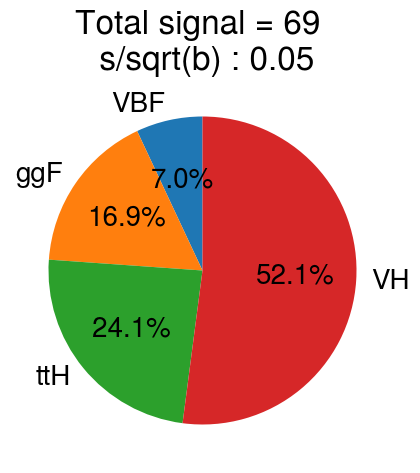

In [16]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(7, 5))
# Create the pie chart

patches, texts, autotexts = ax.pie(num_sig.values(), labels=num_sig.keys(), autopct='%1.1f%%', startangle=90)
for text in texts:
    text.set_size(20)
for autotext in autotexts:
    autotext.set_color('black')
    
# Add a title
plt.title(f"Total signal = {sum(list(num_sig.values())):.0f} \n s/sqrt(b) : {deno_sig/math.sqrt(deno_bkg):.2f}")

plt.show()

# Check s/b as a function of a cut

In [10]:
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

In [83]:
mass_window = [100, 150]

tagger = "fj_ParT_score_finetuned"

dphi_cuts = [0, 0.785, 1.57, 2.355]
tagger_cuts = [0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 0.99]

s_over_b = {}
for dphi_cut in dphi_cuts:
    s_over_b[dphi_cut] = []
    for tagger_cut in tagger_cuts:  
        s,b = 0, 0
        for year in years:
            for ch in channels:
                for sample in samples:
                    if sample=="Data":
                        continue

                    region, sel = list(presel.items())[0]

                    df = events_dict[year][ch][sample]

#                     df = df.query(sel)  

                    df = df[df[f"{tagger}"]>tagger_cut]
                    
                    if dphi_cut != 0:
                        df = df[df["abs_met_fj_dphi"]<dphi_cut]

                    ######################## soverb start
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    if sample in utils.signals:                
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()
                    ######################## soverb end  
        s_over_b[dphi_cut].append(s/math.sqrt(b))

In [80]:
s_over_b

{0: [1.2359645098308436,
  1.3082874263931858,
  1.4035161176242001,
  1.4752758907338137,
  1.5860957954233987,
  1.800347094327339,
  1.4356925415858555],
 0.785: [1.2147695763405515,
  1.2972275324768616,
  1.3685506847939561,
  1.45181305902591,
  1.5390064021725118,
  1.7752611840372694,
  1.4050156988568454],
 1.57: [1.2324709073783089,
  1.305152701927036,
  1.3999773100592192,
  1.474165949781902,
  1.5847177267034562,
  1.7985981788128405,
  1.4344977601296003],
 2.355: [1.2359645098308436,
  1.3082874263931858,
  1.4035161176242001,
  1.4752758907338137,
  1.5860957954233987,
  1.800347094327339,
  1.4356925415858555]}

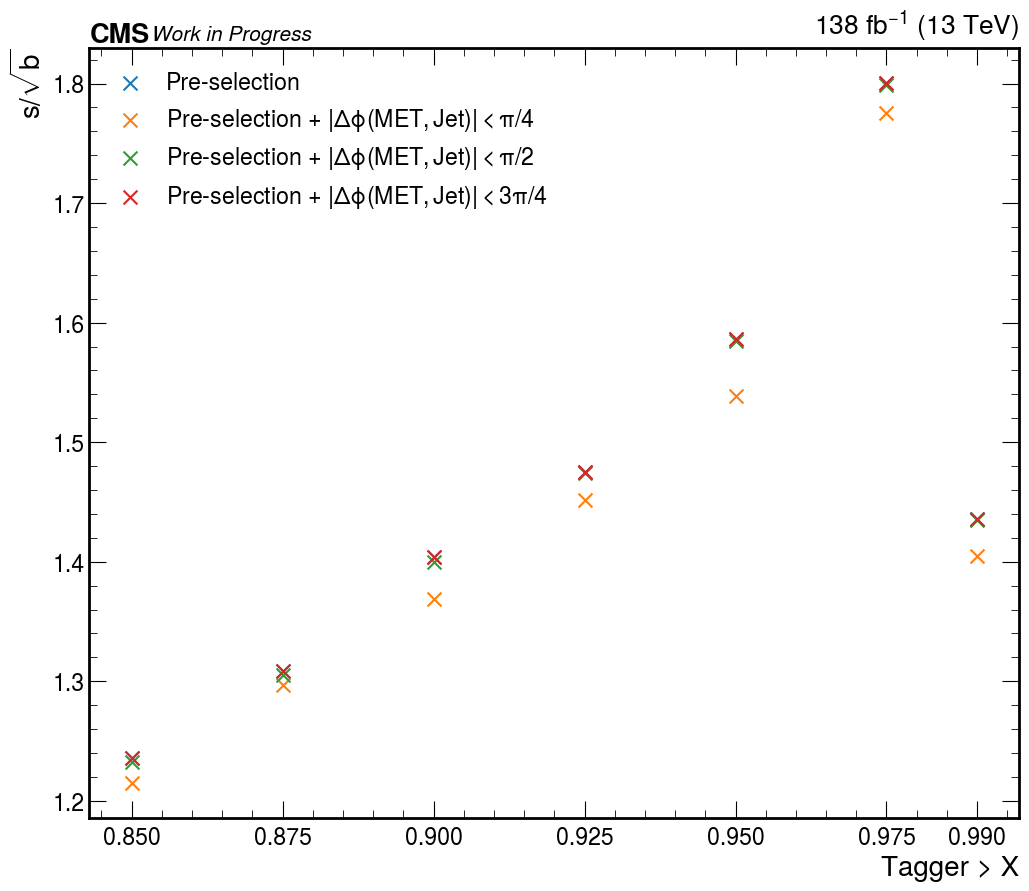

In [84]:
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(12, 10))
for dphi_cut in s_over_b:
    
    lab = "Pre-selection"
    if dphi_cut == 0.785:
        lab += r" + $\left| \Delta \phi(MET, Jet) \right| < \pi/4 $"
    elif dphi_cut == 1.57:
        lab += r" + $\left| \Delta \phi(MET, Jet) \right| < \pi/2 $"   
    elif dphi_cut == 2.355:
        lab += r" + $\left| \Delta \phi(MET, Jet) \right| < 3\pi/4 $"
        
    ax.scatter(tagger_cuts, s_over_b[dphi_cut], marker="x", s=100, label=lab)

ax.legend()
ax.set_ylabel(r"$s/\sqrt{b}$"); 
ax.set_xlabel(r"Tagger > X");

ax.set_xticks(tagger_cuts)

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig("/Users/fmokhtar/Desktop/AN/soverb-dphi.pdf")

In [25]:
dr_cuts = np.linspace(0.1,0.8,21)

s_over_b = {}
for tagger_cut in [0, 0.9, 0.99]:
    s_over_b[tagger_cut] = []
    
    for dr_cut in dr_cuts:
        num_sig, num_bkg = {}, {}
        deno_sig, deno_bkg = 0, 0
        s, b = 0, 0
        for sample in ["HWW", "ttH", "VBF", "VH", "TTbar", "QCD", "WJetsLNu", "DYJets"]:

            df_mu = events_dict["2017"]["mu"][sample]
            df_ele = events_dict["2017"]["ele"][sample]

            ### signal region
            # add tagger cut
            df_mu = df_mu[df_mu["inclusive_score"]>tagger_cut]
            df_ele = df_ele[df_ele["inclusive_score"]>tagger_cut]

            # dR cut
            df_mu = df_mu[df_mu["lep_fj_dr"]<dr_cut]
            df_ele = df_ele[df_ele["lep_fj_dr"]<dr_cut] 
            
            # nbjets?
            df_mu = df_mu[df_mu["n_bjets_M"]<2]
            df_ele = df_ele[df_ele["n_bjets_M"]<2]            
            
            ##############################    
            if sample in utils.signals:
                num_sig[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_sig += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
            else:
                num_bkg[sample] = df_mu["event_weight"].sum() + df_ele["event_weight"].sum()
                deno_bkg += df_mu["event_weight"].sum() + df_ele["event_weight"].sum()

        s_over_b[tagger_cut].append(deno_sig/math.sqrt(deno_bkg))

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

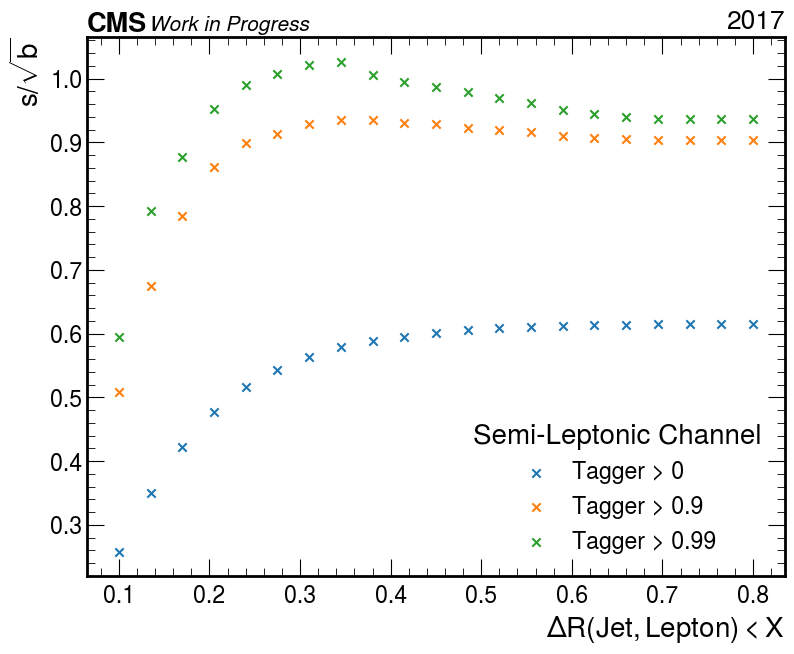

In [26]:
plt.rcParams.update({"font.size": 20})
### save plot
fig, ax = plt.subplots(figsize=(9, 7))
for tagger_cut in s_over_b:
    ax.scatter(dr_cuts, s_over_b[tagger_cut], marker="x", label=f"Tagger > {tagger_cut}")

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"$s/\sqrt{b}$"); 
ax.set_xlabel(r"$\Delta R(Jet,Lepton) < X$");
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# Optimum finding algorithm

In [40]:
from tqdm.notebook import tqdm
def get_optimum_s_over_b(vars_, steps, apply_tagger=False):
    """
    Idea: given a range, fix the lower limit and do a "for loop" where you slide the upper limit to the left until 
    you hit the lower limit. Then increase the lower limit by one step and repeat.
    
    NOTE: for computational costs, and assuming the steps are always about a nice gaussian;
    the lower limit does not bypass the midpoint.
    """

    s, b = {}, {}
    
    midpoint = steps.mean()
    for low in tqdm(steps):
        if low>midpoint:
            break
        for high in tqdm(steps):
            if high<=low:
                continue
        
            s[f"{low:.2f}-{high:.2f}"], b[f"{low:.2f}-{high:.2f}"] = 0, 0
        
            for ch in channels:   # sum over channels
                for sample in events_dict["2017"][ch]:
                    df = events_dict["2017"][ch][sample]

                    ### apply tagger cut
                    if apply_tagger:
                        keep = ( df["inclusive_score"]>0.9 )
                        df = df.loc[keep, :]

                    # selection
                    if len(vars_)==2:
                        keep = ( df[vars_[0]]/df[vars_[1]]>low ) & ( df[vars_[0]]/df[vars_[1]]<high ) 
                    else:
                        keep = ( df[vars_[0]]>low ) & ( df[vars_[0]]<high )
    
                    df = df.loc[keep, :]            

                    ### mass window
                    mass_window = (df["fj_minus_lep_m"]>0) & (df["fj_minus_lep_m"]<150)

                    ### s/b
                    ev_weight = df["event_weight"]        
                    if sample in utils.signals:
                        s[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()
                    else:
                        b[f"{low:.2f}-{high:.2f}"] += ev_weight[mass_window].sum()   
         
    max_ = 0
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            max_ = s_over_b
    
    for range_ in s:
        s_over_b = s[range_]/np.sqrt(b[range_])
        if s_over_b >= max_:
            print("range: s/b")    
            print(f"{range_} : {s[range_]/np.sqrt(b[range_]):.2f}")    
        
    return s, b

# dR(Jet,Lepton)

In [43]:
steps = np.linspace(0, 0.8, 11)
steps 

array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ])

In [44]:
s, b = get_optimum_s_over_b(["lep_fj_dr"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-0.40 : 0.66


# pT(Jet)/pT(Lepton)

In [46]:
steps = np.linspace(0, 10, 11)
steps 

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [47]:
s, b = get_optimum_s_over_b(["fj_pt", "lep_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-10.00 : 0.65
range: s/b
1.00-10.00 : 0.65


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:52: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])
/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_62462/2161202164.py:57: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b = s[range_]/np.sqrt(b[range_])


# pT(W_lnu)/pT(W_qq)

In [48]:
steps = np.linspace(0, 10, 11)
steps

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [49]:
s, b = get_optimum_s_over_b(["rec_W_lnu_pt", "rec_W_qq_pt"], steps, apply_tagger=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

range: s/b
0.00-9.00 : 0.65
